# Retrieve all the relevant data from the table athletic-data in the database.
# Pre-requisite :
  1. Activity has to be of more than 2hrs.
  2. Watts and HeartRate column should not be null.

In [175]:
%reset
import pandas as pd

from src.config.LoadProperties import retrieve_data_sql
from src.repositories.PowerAndHRRepository import configs, sql_engine
year = 2021
athlete_id = 863203

"""
Read and return athletic data from a SQL database.

:return: A pandas DataFrame containing the athletic data.
"""

def get_athletic_data(id, activity_year):
    return pd.read_sql(retrieve_data_sql.replace("(athlete_id)",str(id)+")").replace("(year)",str(activity_year)), sql_engine)

athletic_data_db = get_athletic_data(athlete_id, year)


# DATA PROFILING : Removing irrelevant columns not required for analysis.

In [176]:
athletic_data = athletic_data_db.drop(configs.get("ignore-columns").data.split(","), axis=1).rename(columns={'watts' : 'power'})
athletic_data['distance'] = athletic_data['distance'].apply(lambda x: [float(value) for value in x])

# Check if the lengths of lists in specified columns are the same for each row


In [177]:
params = ['heartrate','power', 'distance', 'time']

def check_lengths(row):
    lengths = [len(row[col]) for col in params]
    return all(length == lengths[0] for length in lengths)

result = athletic_data[athletic_data.apply(check_lengths, axis=1)]
count_different_lengths = len(athletic_data) - len(result)

print(f"Count of activity IDs with different lengths: {count_different_lengths}")

Count of activity IDs with different lengths: 0


# NA/NONE CHECK : Checking if power, distance, time and heartrate column contains None/NaN values

In [179]:
def check_nan_entries(data, param):
    none_count = data.apply(lambda x: any(item is None for item in x) if x is not None else False).sum()
    print(f"{none_count}/{len(data)} entries contains None in "  + param)
    nan_count = data.apply(lambda x: any(pd.isna(item) for item in x) if x is not None else False).sum()
    print(f"{nan_count}/{len(data)} entries contains NaN in "  + param)

for i, val in enumerate(params):
    check_nan_entries(athletic_data[val], val)


activity_id_to_extract = 6399104761
# 
selected_activity = athletic_data[athletic_data['activity_id'] == activity_id_to_extract]
# 
orig_power_df = pd.DataFrame({'power': selected_activity['power'].iloc[0]})
orig_hr_df = pd.DataFrame({'hr': selected_activity['heartrate'].iloc[0]})
orig_time_df = pd.DataFrame({'time': selected_activity['time'].iloc[0]})
orig_distance_df = pd.DataFrame({'distance': selected_activity['distance'].iloc[0]})

# power_df_ip = pd.DataFrame({'power_ip': selected_activity['power_ip'].iloc[0]})
# segment_index = pd.DataFrame({'segment_start_index': selected_activity['segment_start_index'].iloc[0]})
NA_comparison_df =  pd.concat([orig_power_df, orig_hr_df, orig_time_df, orig_distance_df], axis=1)

0/258 entries contains None in heartrate
0/258 entries contains NaN in heartrate
94/258 entries contains None in power
94/258 entries contains NaN in power
0/258 entries contains None in distance
0/258 entries contains NaN in distance
0/258 entries contains None in time
0/258 entries contains NaN in time


# Continuity Check : Checking if data in time column in evenly spaced/incremented by only 1.


In [157]:
# def check_increment(row):
#     if not all(b == a + 1 for a, b in zip(row['time'][:-1], row['time'][1:])):
#         return row['activity_id']
#     return None
# 
# abc['result'] = athletic_data.apply(check_increment, axis=1)
# 
# # The 'result' column will contain the 'activity_id' where the values are not incremented by 1
# filtered_result = athletic_data['result'].dropna().astype(int)
# 
# print(filtered_result)
# 
# result_dataframe = athletic_data[athletic_data['activity_id'] == 6399104761][['time']].explode('time', ignore_index=True)


# Cluster view of how long the NA/None/Null entries exists.

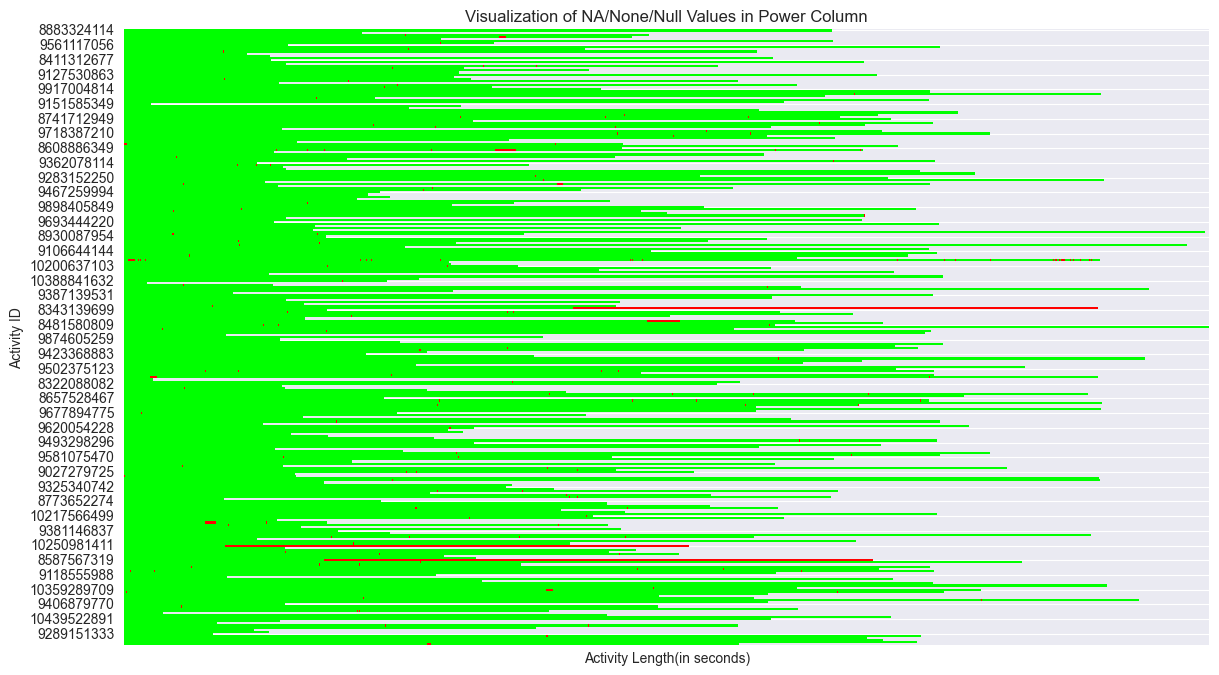

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

athletic_data_with_na = pd.DataFrame(index=athletic_data['activity_id'], columns=range(len(max(athletic_data['power'], key=len))))
 
for idx, powers in zip(athletic_data['activity_id'], athletic_data['power']):
    athletic_data_with_na.loc[idx, :len(powers) - 1] = pd.Series(powers).isna().values

athletic_data_with_na = athletic_data_with_na.astype(float)

cmap = sns.color_palette(['#00FF00', '#FF0000'])

plt.figure(figsize=(14, 8))
sns.heatmap(data=athletic_data_with_na, cmap=cmap, cbar=False, xticklabels=False) 
plt.title('Visualization of NA/None/Null Values in Power Column')
plt.xlabel('Activity Length(in seconds)')
plt.ylabel('Activity ID')
plt.show()

# Visualization of the length of NA/None/Null Values in Power Column

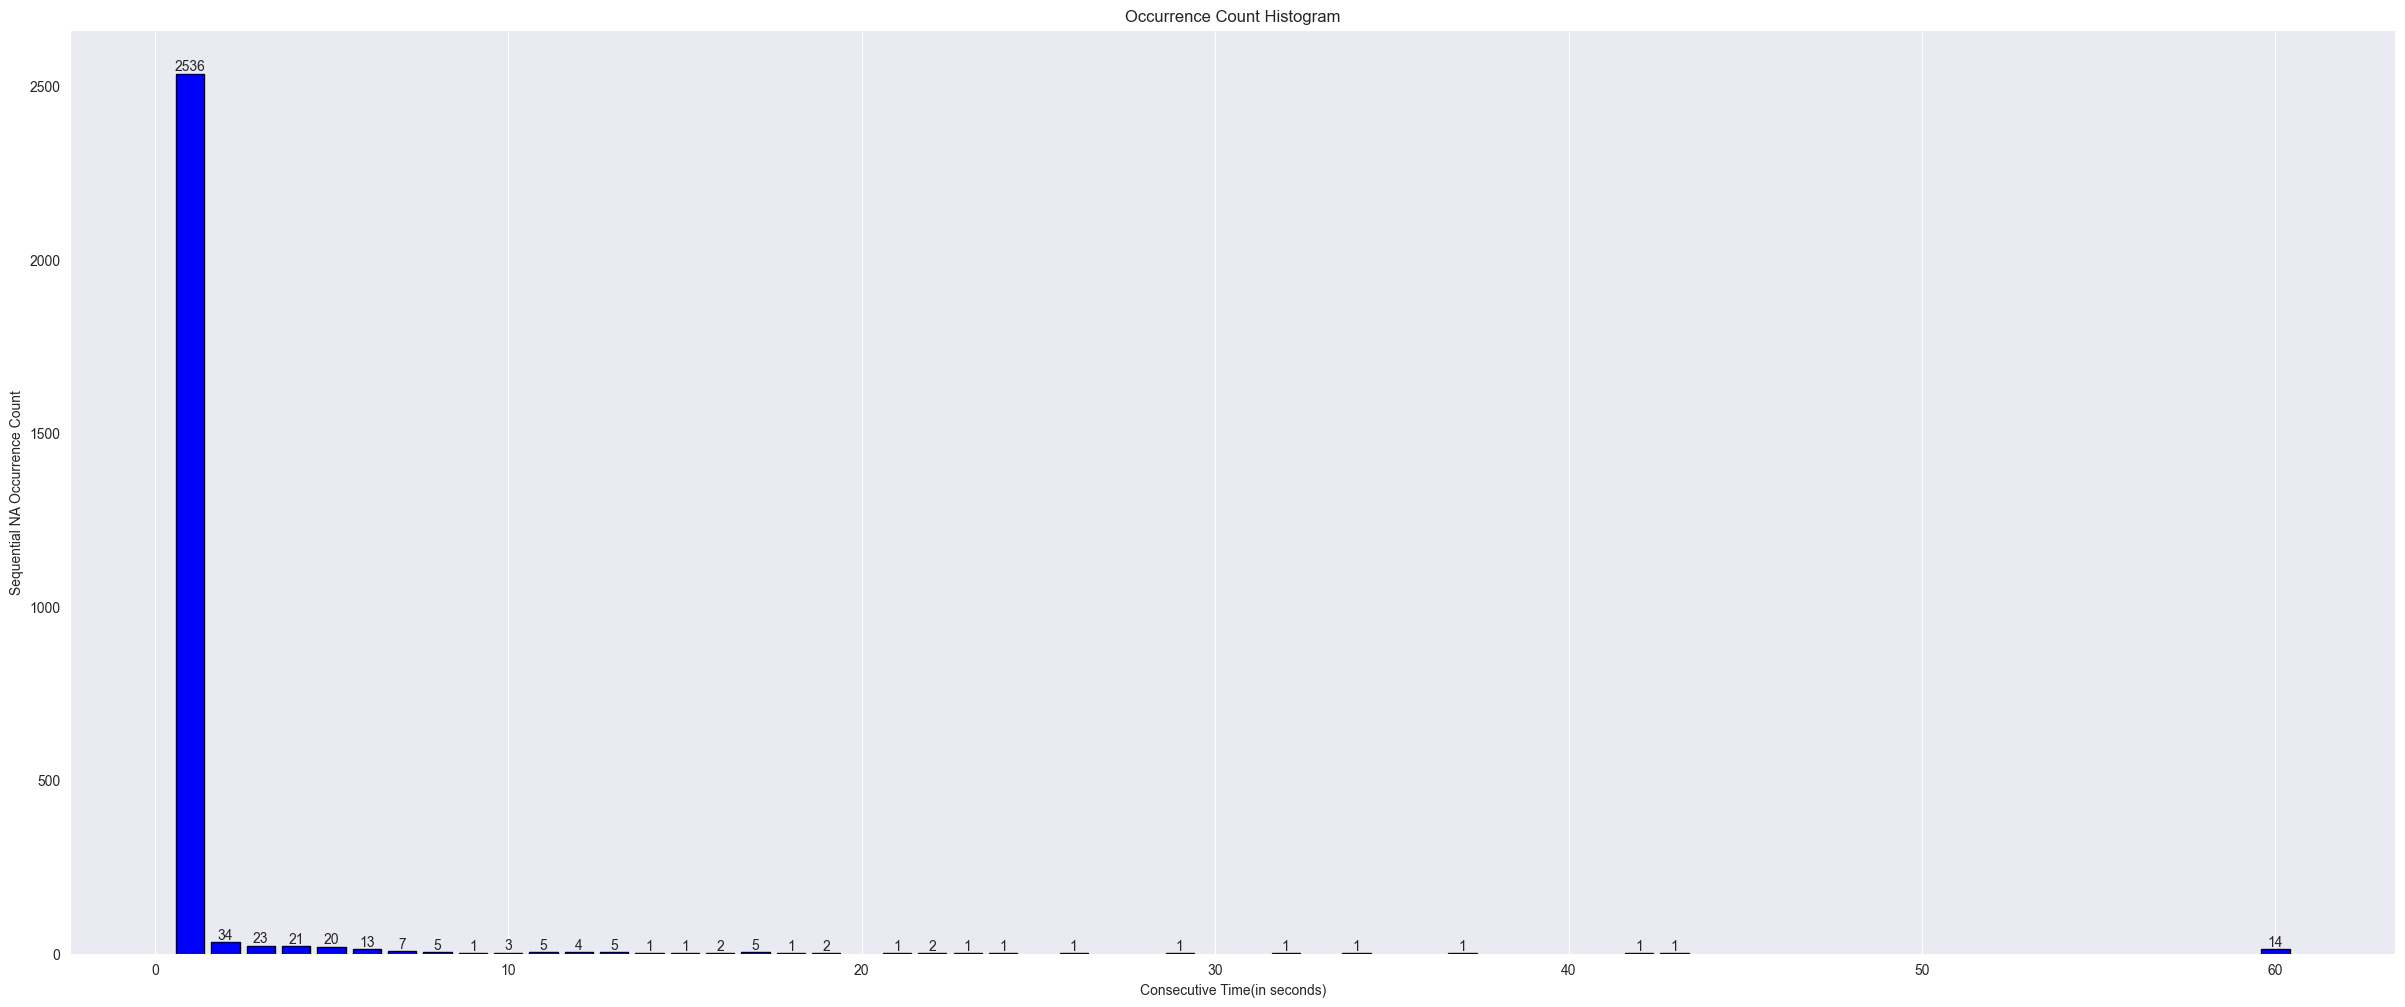

In [159]:
import matplotlib.pyplot as plt
from itertools import groupby
from collections import Counter

cons_na_pow_list = athletic_data['power'].apply(lambda x: [0] + [len(list(g)) for k, g in groupby(x) if pd.isna(k)]).tolist()

def count_occurrences(na_list):
    flat_list = [min(num, 60) for sublist in na_list for num in sublist if num != 0]
    occurrences = Counter(flat_list)
    return dict(occurrences)

seq_na_occ_count = count_occurrences(cons_na_pow_list)

plt.figure(figsize=(30, 12))

plt.bar(seq_na_occ_count.keys(), seq_na_occ_count.values(), color='blue', edgecolor='black')

for key, value in seq_na_occ_count.items():
    plt.text(key, value, str(value), ha='center', va='bottom')


plt.title('Occurrence Count Histogram')
plt.xlabel('Consecutive Time(in seconds)')
plt.ylabel('Sequential NA Occurrence Count') 
plt.grid(axis='y')
plt.show()

# Interpolation : Applying Linear Interpolation only for NA/None occurring for maximum 5 seconds in the power data recorded.

In [172]:
na_limit = 5

def interpolate_nan(sublist):

    inter_list = pd.Series(sublist).interpolate(limit_direction='both').tolist()[1:] 
    rd_inter_list = [round(i_val) for i_val in inter_list]
    
    return rd_inter_list


def interpolate_none_values(orig_list, na_limit):
    interpolated_list = []
    count = 0
    for i, val in enumerate(orig_list):
        if val is None:
            if len(orig_list)-1 != i:                                                  # if na_occurrence not at the end of the list
                count += 1
            else:                                                                     # if na_occurrence is at the end of the list
                interpolated_list.extend(orig_list[-count:])
                interpolated_list.append(val) 
        else:
            if na_limit >= count > 0 != i-count:                                        # when found non-NA before and after NA AND na_occurrence <= na_limit
                sublist = orig_list[i - count - 1 : i + 1 ]
                interpolated_list.extend(interpolate_nan(sublist)) 
                count = 0
            elif (na_limit >= count > 0 == i-count) or count > na_limit:              # when series start with NA and non-NA found after NA AND na_occurrence <= na_limit
                interpolated_list.extend([None] * count)
                interpolated_list.append(val)
                count = 0
            else:                                                                     # when another non-NA found after non-NA
                interpolated_list.append(val)
            
    return interpolated_list

interpolated_power = [interpolate_none_values(seq, na_limit) for seq in athletic_data['power']]

# Adding Index column of segment starting index


In [173]:
athletic_data['power_ip'] = interpolated_power

#athletic_data['power_ip_na_adjusted'] = athletic_data['power_ip'].apply(lambda x: [x[i] for i in range(len(x)) if pd.notna(x[i])])


#list_a = [1, 4, 5, None, None, None, 4, 5, 9, None, 4, 5, None, None, 3, 8, 10, None]
#[1, 4, 5, 4, 5, 9, 4, 5, 3, 8, 10]
#[0, 1, 2, 6, 7, 8, 10, 11, 14, 15, 16]
#[0, 3, 6, 8]
#list_ax = [None, 1, 4, 5, None, None, None, 4, 5, None, 2, 3, 9, None, None, 3, 8, 10, None]
#[1, 4, 5, 4, 5, 2, 3, 9, 3, 8, 10]
#[1, 2, 3, 7, 8, 10, 11, 12, 15, 16, 17]
#[0, 3, 5, 8]
def find_segment_start_indices(original_list):
    non_none_indices = [i for i, val in enumerate(original_list) if pd.notna(val)]

    segment_index_list = []
    sub_index = []
    for i in range(0, len(non_none_indices)):
        if i == 0  and non_none_indices[i] >= 0:
            sub_index.append(non_none_indices[i])
        if non_none_indices[i] > non_none_indices[i-1] + 1:
            sub_index.append(non_none_indices[i-1])
            segment_index_list.append(sub_index)
            sub_index = [non_none_indices[i]]
        if i == len(non_none_indices)-1:
            sub_index.append(non_none_indices[i])
            segment_index_list.append(sub_index)
    return segment_index_list
# 
# print(find_segment_start_indices(list_a))
# print(find_segment_start_indices(list_ax))

athletic_data['segment_start_index'] = athletic_data.apply(lambda row: find_segment_start_indices(row['power_ip']), axis=1)

# NA Replacement Check

In [162]:
# import pandas as pd
# from itertools import groupby
# 
# consec_na_len = 7
# athletic_data['consec_na_power'] = athletic_data['power'].apply(lambda x: [0] + [len(list(g)) for k, g in groupby(x) if pd.isna(k)])
# athletic_data['consec_na_power_ip'] = athletic_data['power_ip'].apply(lambda x: [0] + [len(list(g)) for k, g in groupby(x) if pd.isna(k)])
# 
# rows_with_cons_na = athletic_data[athletic_data['consec_na_power'].apply(lambda x: consec_na_len in x)]
# rows_with_cons_na_ip = athletic_data[athletic_data['consec_na_power_ip'].apply(lambda x: consec_na_len in x)]
# 
# if not rows_with_cons_na.empty:
#     athletic_ids_with_na = rows_with_cons_na['activity_id'].tolist()
#     print(f"Activity IDs with {consec_na_len} consecutive NAs: {athletic_ids_with_na}")
# if not rows_with_cons_na_ip.empty:
#      athletic_ids_with_na_ip = rows_with_cons_na_ip['activity_id'].tolist()
#      print(f"Activity IDs with {consec_na_len} consecutive NAs: {athletic_ids_with_na_ip}")
# else:
#     print("No rows with "+ consec_na_len + "consecutive NAs found.")


# Position of the NA in the power list

In [174]:
# activity_id_to_extract = 6399104761
# 
# selected_activity = athletic_data[athletic_data['activity_id'] == activity_id_to_extract]
# 
# orig_power_df = pd.DataFrame({'power': selected_activity['power'].iloc[0]})
# power_df_ip = pd.DataFrame({'power_ip': selected_activity['power_ip'].iloc[0]})
# segment_index = pd.DataFrame({'segment_start_index': selected_activity['segment_start_index'].iloc[0]})
# NA_comparison_df =  pd.concat([orig_power_df, power_df_ip, segment_index], axis=1)


activity_id_to_extract = 6399104761
# 
selected_activity_2 = athletic_data[athletic_data['activity_id'] == activity_id_to_extract]
# 
orig_power_df_2 = pd.DataFrame({'power': selected_activity_2['power'].iloc[0]})
orig_hr_df_2 = pd.DataFrame({'hr': selected_activity_2['heartrate'].iloc[0]})
orig_time_df_2 = pd.DataFrame({'time': selected_activity_2['time'].iloc[0]})
pow_ip_df = pd.DataFrame({'power_ip': selected_activity_2['power_ip'].iloc[0]})

# power_df_ip = pd.DataFrame({'power_ip': selected_activity['power_ip'].iloc[0]})
# segment_index = pd.DataFrame({'segment_start_index': selected_activity['segment_start_index'].iloc[0]})
NA_comparison_df_2 =  pd.concat([orig_power_df_2, orig_hr_df_2, orig_time_df_2, pow_ip_df], axis=1)

# Choosing the longest continuous segments of each of the rides

In [164]:
def find_longest_segment_indices(lst):
    if not lst:
        return [None, None]

    start_index, end_index = 0, 0
    current_start, current_end = 0, 0
    max_length = 1

    for i in range(1, len(lst)):
        if lst[i] == lst[i - 1] + 1:
            current_end = i
        else:
            current_start = i
            current_end = i

        current_length = current_end - current_start + 1

        if current_length > max_length:
            start_index, end_index = current_start, current_end
            max_length = current_length

    return [start_index, end_index]

#athletic_data['longest_time_segment'] = athletic_data['time'].apply(find_longest_segment_indices)


# Calculating datapoints of all the activities

In [165]:
get_list_length = lambda x: len(x) if isinstance(x, list) else 0

athletic_data['datapoints'] = athletic_data['power_ip'].apply(get_list_length)

# Converting Dataframe into CSV for further analysis in MATLAB

In [166]:
import os
import pandas as pd

df = pd.DataFrame(athletic_data)

athlete_name="Connor Swift"

csv_directory = f'Strava Data/{athlete_name}'
csv_path = f'{csv_directory}/{athlete_name}_{athlete_id}_{year}.csv'

if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)

df.to_csv(csv_path, index=False)


print(f"DataFrame has been successfully converted to CSV and saved at: {csv_path}")

DataFrame has been successfully converted to CSV and saved at: Strava Data/Connor Swift/Connor Swift_863203_2023.csv
